**Import des données / Lib**

In [7]:
# 📦 Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score


df = pd.read_parquet('../data/parquet/full_2020.csv.parquet', engine='pyarrow')

**Optimisation**

In [8]:
# Liste des colonnes à supprimer (remplissage < 10%)
cols_to_drop_1 = [
    'ancien_code_commune', 'ancien_nom_commune', 'ancien_id_parcelle',
    'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez',
    'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez',
    'lot5_numero', 'lot5_surface_carrez'
]
# Liste des colonnes avec infos inutiles
cols_to_drop_2 = [
    'id_mutation', 'numero_disposition', 'adresse_numero', 'adresse_suffixe',
    'adresse_nom_voie', 'adresse_code_voie', 'nom_commune', 'id_parcelle',
    'numero_volume', 'code_nature_culture', 'nature_culture','code_nature_culture_speciale'
]
df.drop(columns=cols_to_drop_1, inplace=True)
# Vérification des colonnes restantes
print(f"Shape after dropping columns: {df.shape}")

def optimize_dataframe(df, parse_dates=None, category_thresh=0.05, verbose=True):
    """
    Optimise les types d'un DataFrame pour réduire l'utilisation mémoire :
    - convertit les objets en catégories si nombre de modalités faible
    - convertit les float64 en float32
    - convertit les int64 en int32
    - convertit les colonnes de dates

    Parameters:
    - df : DataFrame à optimiser
    - parse_dates : liste de colonnes à parser comme dates
    - category_thresh : seuil max de ratio modalité/nb lignes pour transformer en 'category'
    - verbose : affiche la mémoire gagnée

    Returns:
    - df optimisé
    """

    initial_memory = df.memory_usage(deep=True).sum() / 1024**2

    # Dates
    if parse_dates:
        for col in parse_dates:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Float → float32
    float_cols = df.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df[col] = df[col].astype('float32')

    # Int → int32
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        if df[col].isnull().any():
            df[col] = df[col].astype('Int32')
        else:
            df[col] = df[col].astype('int32')

    # Object → category si peu de modalités
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique(dropna=False) / len(df) <= category_thresh:
            df[col] = df[col].astype('category')

    final_memory = df.memory_usage(deep=True).sum() / 1024**2

    if verbose:
        print(f"💾 Mémoire utilisée : {initial_memory:.2f} Mo → {final_memory:.2f} Mo ({100 * (1 - final_memory/initial_memory):.1f}% gagné)")

    return df

# Application test sur ech_annonces_ventes_68.csv
optimized_df1 = optimize_dataframe(df, parse_dates=['date_mutation'], verbose=True)
optimized_df1.info()
optimized_df1.head()


Shape after dropping columns: (3522416, 27)
💾 Mémoire utilisée : 2855.43 Mo → 862.50 Mo (69.8% gagné)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522416 entries, 0 to 3522415
Data columns (total 27 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id_mutation                   object        
 1   date_mutation                 datetime64[ns]
 2   numero_disposition            int32         
 3   nature_mutation               category      
 4   valeur_fonciere               float32       
 5   adresse_numero                float32       
 6   adresse_suffixe               category      
 7   adresse_nom_voie              object        
 8   adresse_code_voie             category      
 9   code_postal                   float32       
 10  code_commune                  category      
 11  nom_commune                   category      
 12  code_departement              category      
 13  id_parcelle                   

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,nom_commune,code_departement,id_parcelle,numero_volume,nombre_lots,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude
0,2020-1,2020-01-07,1,Vente,8000.0,NaN,NaN,FORTUNAT,B063,1250.0,01072,Ceyzériat,01,01072000AK0216,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1061.0,5.323532,46.171940
1,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,TERRES DES CINQ SAULES,B124,1290.0,01203,Laiz,01,012030000B0004,NaN,0,NaN,NaN,NaN,NaN,BT,taillis simples,NaN,NaN,85.0,4.893454,46.251858
2,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,BOIS DU CHAMP RION,B006,1290.0,01203,Laiz,01,012030000B0173,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1115.0,4.900210,46.235275
3,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,EN COROBERT,B025,1290.0,01203,Laiz,01,012030000B0477,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1940.0,4.882112,46.246555
4,2020-2,2020-01-02,1,Vente,2175.0,NaN,NaN,TERRES DES CINQ SAULES,B124,1290.0,01203,Laiz,01,012030000C0068,NaN,0,NaN,NaN,NaN,NaN,T,terres,NaN,NaN,1148.0,4.894481,46.251842


**Split**

In [9]:
# Vérification si le DataFrame est vide
if optimized_df1.empty:
    raise ValueError("Le DataFrame 'optimized_df1' est vide après suppression des valeurs manquantes.")

# Calcul de la fréquence des communes
commune_freq = optimized_df1['nom_commune'].value_counts()
optimized_df1['commune_freq'] = optimized_df1['nom_commune'].map(commune_freq)

# Création de la colonne 'coordonnees'
optimized_df1['coordonnees'] = list(zip(optimized_df1['latitude'], optimized_df1['longitude']))

# Colonnes choisies
colonnes_choisies = [
    'valeur_fonciere', 'surface_terrain', 'surface_reelle_bati',
    'code_type_local', 'nombre_pieces_principales',
    'commune_freq', 'nombre_lots'
]

# Vérification des colonnes manquantes
colonnes_manquantes = [col for col in colonnes_choisies if col not in optimized_df1.columns]
if colonnes_manquantes:
    raise ValueError(f"Les colonnes suivantes sont manquantes dans 'optimized_df1' : {colonnes_manquantes}")

# Création du DataFrame final
dfRFR = optimized_df1[colonnes_choisies].copy()
# Suppression des valeurs manquantes
dfRFR = dfRFR.dropna()
# Vérification si le DataFrame est vide
if dfRFR.empty:
    raise ValueError("Le DataFrame 'dfRFR' est vide après sélection des colonnes.")

# Définir X (features) et y (target)
X = dfRFR.drop(columns='valeur_fonciere')
y = dfRFR['valeur_fonciere']

# Vérification si X ou y sont vides
if X.empty or y.empty:
    raise ValueError("Les données pour 'X' ou 'y' sont vides. Vérifiez le contenu de 'dfRFR'.")

# Ajuster test_size si nécessaire
test_size = 0.2
if len(dfRFR) < 5:
    test_size = 1 / len(dfRFR)

# Découper en train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

print("Split effectué avec succès !")
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

Split effectué avec succès !
Taille de l'ensemble d'entraînement : 690602
Taille de l'ensemble de test : 172651


**Premiere prediction**

(690602, 6) (172651, 6)
RMSE : 2569145.9906352833
R² : 0.9501699724782149


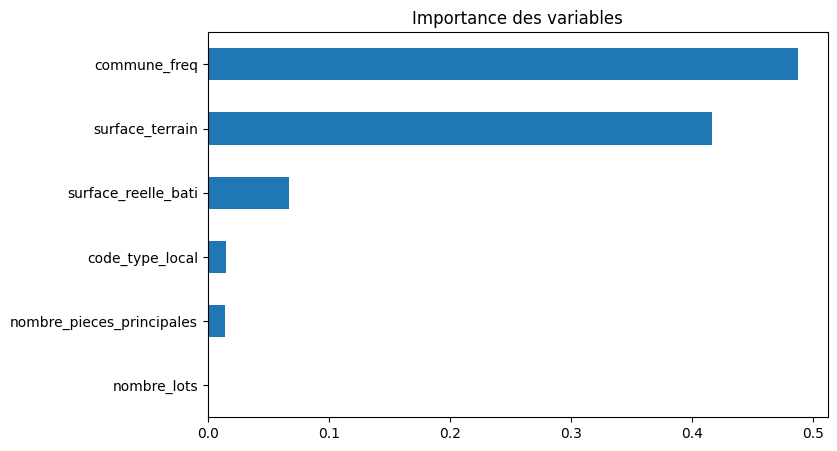

<class 'pandas.core.frame.DataFrame'>
Index: 863253 entries, 11 to 3522414
Data columns (total 7 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   valeur_fonciere            863253 non-null  float32
 1   surface_terrain            863253 non-null  float32
 2   surface_reelle_bati        863253 non-null  float32
 3   code_type_local            863253 non-null  float32
 4   nombre_pieces_principales  863253 non-null  float32
 5   commune_freq               863253 non-null  int64  
 6   nombre_lots                863253 non-null  int32  
dtypes: float32(5), int32(1), int64(1)
memory usage: 32.9 MB


In [10]:
print(X_train.shape, X_test.shape)

model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)  # RMSE ici
r2 = r2_score(y_test, y_pred)

print("RMSE :", rmse)
print("R² :", r2)


importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(8,5))
plt.title("Importance des variables")
plt.show()

dfRFR.info()

**Shap**

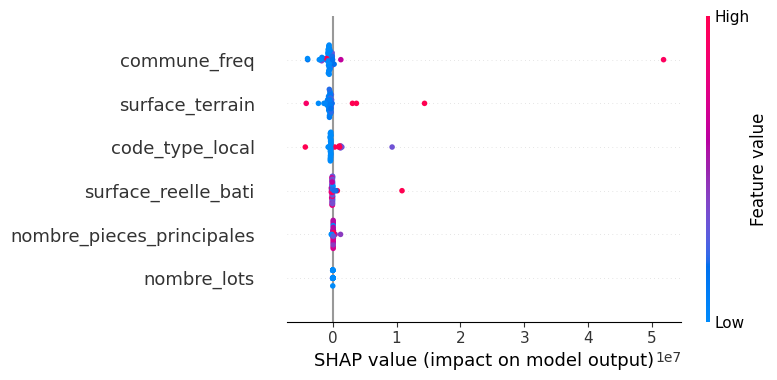

In [11]:
explainer = shap.TreeExplainer(model)

sample = X_test.sample(50)  # par exemple
shap_values = explainer.shap_values(sample)

shap.summary_plot(shap_values, sample, plot_type="dot")

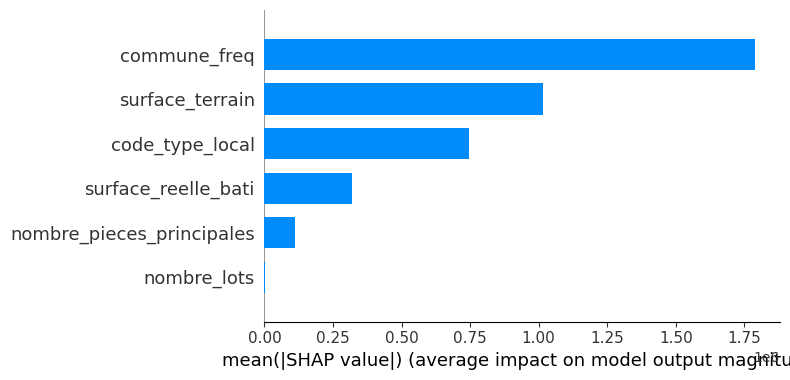

In [12]:
shap.summary_plot(shap_values, sample, plot_type="bar")